# Calculating Forest Canopy Density from Landsat 8 Image

# Import Modules

In [1]:
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.listdir('C:/ITC/Landsat 8 Image')

['Inputs',
 'LC08_L2SP_197023_20200419_20200822_02_BLUE.TIF',
 'LC08_L2SP_197023_20200419_20200822_02_BLUE.TIF.aux.xml',
 'LC08_L2SP_197023_20200419_20200822_02_BLUE.TIF.xml',
 'LC08_L2SP_197023_20200419_20200822_02_GREEN.TIF',
 'LC08_L2SP_197023_20200419_20200822_02_NIR.TIF',
 'LC08_L2SP_197023_20200419_20200822_02_RED.TIF',
 'LC08_L2SP_197023_20200419_20200822_02_SWIR.TIF',
 'LC08_L2SP_197023_20200419_20200822_02_TIR.TIF',
 'Outputs']

# Setting np error (Allowing Division by 0)

In [3]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Read raster files from path defined

In [4]:
BlueBand = rasterio.open('C:/ITC/Landsat 8 Image/LC08_L2SP_197023_20200419_20200822_02_BLUE.TIF')
GreenBand = rasterio.open('C:/ITC/Landsat 8 Image/LC08_L2SP_197023_20200419_20200822_02_GREEN.TIF')
RedBand = rasterio.open('C:/ITC/Landsat 8 Image/LC08_L2SP_197023_20200419_20200822_02_RED.TIF')
NIRBand = rasterio.open('C:/ITC/Landsat 8 Image/LC08_L2SP_197023_20200419_20200822_02_NIR.TIF')
SWIRBand = rasterio.open('C:/ITC/Landsat 8 Image/LC08_L2SP_197023_20200419_20200822_02_SWIR.TIF')
TIRBand = rasterio.open('C:/ITC/Landsat 8 Image/LC08_L2SP_197023_20200419_20200822_02_TIR.TIF')

# Convert data into float

In [5]:
blue= BlueBand.read(1).astype('float')
green= GreenBand.read(1).astype('float')
red = RedBand.read(1).astype('float')
nir = NIRBand.read(1).astype('float')
swir = SWIRBand.read(1).astype('float')
tir = TIRBand.read(1).astype('float')

# Set no data to 0

In [6]:
blue[blue==np.nan] = 0
green[green==np.nan] = 0
nir[nir==np.nan] = 0
swir[swir==np.nan] = 0
tir[tir==np.nan] = 0

# Calculate AVI

In [7]:
avi = np.where((nir-red) <0,0,((nir+1)*(65536-nir)*(nir-red))**(1/3))

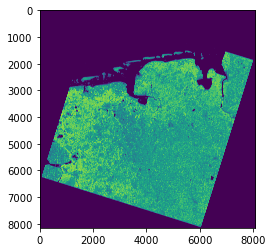

<AxesSubplot:>

In [8]:
plot.show(avi)

# Calculate BSI

In [9]:
BSI = np.where(((swir+nir)+(nir+blue))<0, 100,(((swir+nir)-(nir+blue))/((swir+nir)+(nir+blue))*100)+100)

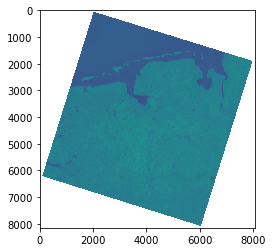

In [10]:
plt.imshow(BSI)

# Calculate CSI

In [11]:
CSI = ((65536-blue)*(65536-green)*(65536-red))**(1/3)

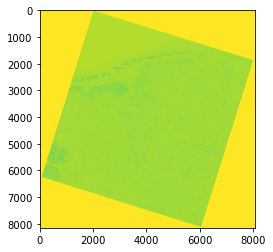

In [12]:
plt.imshow(CSI)

# Calculate TI

In [13]:
Lambda = (0.000342 * tir) + 0.1

In [14]:
TI = (1201.1422/(np.log((480.883/Lambda)+1.0)))-273.15

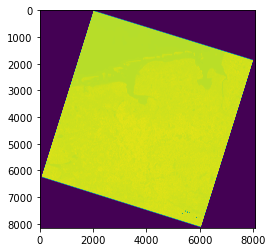

In [15]:
plt.imshow(TI)

# Save indices

In [17]:
with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/AVI_JN.tif', 'w',driver='Gtiff',
                        width=NIRBand.width,
                        height=NIRBand.height,
                        count=1,
                        crs=NIRBand.crs,
                        transform=NIRBand.transform,
                        dtype='float32') as AVIimage:
            AVIimage.write_band(1, avi.astype(rasterio.float32))

with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/BSI_JN.tif', 'w',driver='Gtiff',
                        width=NIRBand.width,
                        height=NIRBand.height,
                        count=1,
                        crs=NIRBand.crs,
                        transform=NIRBand.transform,
                        dtype='float32') as BSIimage:
            BSIimage.write_band(1, BSI.astype(rasterio.float32))

with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/CSI_JN.tif', 'w',driver='Gtiff',
                        width=RedBand.width,
                        height=RedBand.height,
                        count=1,
                        crs=RedBand.crs,
                        transform=RedBand.transform,
                        dtype='float32') as CSIimage:
            CSIimage.write_band(1, CSI.astype(rasterio.float32))

with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/TI_JN.tif', 'w',driver='Gtiff',
                        width=TIRBand.width,
                        height=TIRBand.height,
                        count=1,
                        crs=TIRBand.crs,
                        transform=TIRBand.transform,
                        dtype='float32') as TIimage:
            TIimage.write_band(1, TI.astype(rasterio.float32))

# Principal Component Analysis

In [18]:
PC1 = np.stack((avi.flatten(), BSI.flatten()), axis = 0)
print('PC1 shape', PC1.shape)

PC1 shape (2, 65705211)


In [19]:
PC1 = np.where(np.isfinite(PC1), PC1, 0)
print('New PC1 shape:',PC1.shape)

New PC1 shape: (2, 65705211)


In [20]:
from sklearn.decomposition import PCA

In [21]:
pca1 = PCA(PC1)

In [22]:
pca1.n_components

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
pca1.n_components.shape

(2, 65705211)

In [24]:
out_pca_t = pca1.n_components
out_pca = np.transpose(out_pca_t)

In [25]:
print('PCA_t', out_pca_t.shape)
print('PCA', out_pca.shape)

PCA_t (2, 65705211)
PCA (65705211, 2)


In [26]:
VD = np.reshape(out_pca[:,0], (NIRBand.height,NIRBand.width))

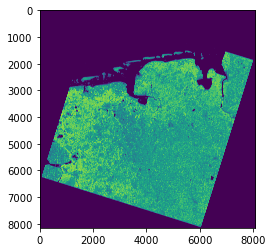

<AxesSubplot:>

In [27]:
plot.show(VD)

In [28]:
VD.shape

(8151, 8061)

# Sclaing Vegetation Density (VD) from 0 - 100

In [29]:
SVD = (VD/np.amax(VD))*100

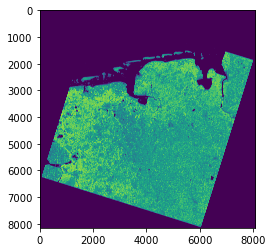

<AxesSubplot:>

In [30]:
plot.show(SVD)

In [31]:
SVD.shape

(8151, 8061)

In [32]:
PC2 =  np.stack((CSI.flatten(), TI.flatten()), axis = 0)
PC2 = np.where(np.isfinite(PC2), PC2, 0)

In [33]:
pca2 = PCA(PC2)

In [34]:
out_pca2_t = pca2.n_components
out_pca2 = np.transpose(out_pca_t)
print('PCA_t', out_pca2_t.shape)
print('PCA', out_pca2.shape)

PCA_t (2, 65705211)
PCA (65705211, 2)


In [35]:
SS = np.reshape(out_pca2[:,0], (RedBand.height,RedBand.width))

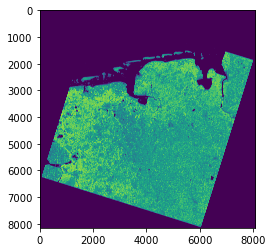

<AxesSubplot:>

In [36]:
plot.show(SS)

# Scaling Shadow Index from 0 - 100

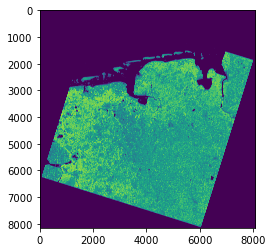

<AxesSubplot:>

In [37]:
SSI = (SS/np.amax(SS))*100
plot.show(SSI)

# Calculate FCD

In [38]:
FCD = (((SVD*SSI)+1)**(1/2)) - 1

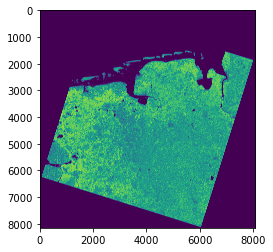

<AxesSubplot:>

In [39]:
plot.show(FCD)

with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/SVD_JN.tif', 'w',driver='Gtiff',
                        width=NIRBand.width,
                        height=NIRBand.height,
                        count=1,
                        crs=NIRBand.crs,
                        transform=NIRBand.transform,
                        dtype='float32') as SVDimage:
            SVDimage.write_band(1, SVD.astype(rasterio.float32))
        
with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/SSI_JN.tif', 'w',driver='Gtiff',
                        width=NIRBand.width,
                        height=NIRBand.height,
                        count=1,
                        crs=NIRBand.crs,
                        transform=NIRBand.transform,
                        dtype='float32') as SSIimage:
           SSIimage.write_band(1, SSI.astype(rasterio.float32))

In [40]:
with rasterio.open('C:/ITC/Landsat 8 Image/Outputs/FCD_JN.tif', 'w',driver='Gtiff',
                        width=NIRBand.width,
                        height=NIRBand.height,
                        count=1,
                        crs=NIRBand.crs,
                        transform=NIRBand.transform,
                        dtype='float64') as FCDimage:
            FCDimage.write_band(1, FCD.astype(rasterio.float64))